# Chapter 3 - Centrality Measures

In this notebook, we explore various centrality measures on a **weighted**, **directed** graph which represents the volume of passengers between US airports in 2008. This dataset is available at: https://www.kaggle.com/flashgordon/usa-airport-dataset#Airports2.csv which is part of the Kaggle Public Datasets: https://www.kaggle.com/datasets

As with the previous notebooks, make sure to set the data directory properly in the next cell.

In [1]:
datadir = '../Datasets/'


In [2]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from statistics import mode
from numpy import inf
from collections import Counter
import random


In [3]:
## define colors from pale to dark
colors = ['gainsboro','silver','darkgray','dimgray','black']

## we will use 3 node sizes:
node_sizes  = [6,9,12]


## US Airport Graph

### Volume of Passengers

The nodes are represented by the 3-letter airport codes such as LAX (Los Angeles); 
each line below represents the number of passenges from ```orig_airport``` to ```dest_airport```.
The last column is the volume of passengers that we use as **edge weights**. Ths we will build a weighted,  directed graph.


In [4]:
## read edges and build weighted directed graph
df = pd.read_csv(datadir+'Airports/connections.csv')
g_airport = ig.Graph.TupleList([tuple(x) for x in df.values], directed=True, edge_attrs=['weight'])
df.head() ## look at a few edges


,orig_airport,dest_airport,total_passengers
0,SFO,LAX,1442105
1,LAX,SFO,1438639
2,MCO,ATL,1436625
3,ATL,MCO,1424069
4,LAX,JFK,1277731


### Node attributes

We read the node attributes in data frame ```Attr```:
* lat/lon, which we will use as the graph layout
* state (2-letter code)
* city

In [5]:
## read vertex attributes and add to graph
Attr = pd.read_csv(datadir+'Airports/airports_loc.csv')
## map airports in Attr to the node order in graph g
lookup = {k:v for v,k in enumerate(Attr['airport'])}
l = [lookup[x] for x in g_airport.vs()['name']]
## save lat/lon as tuples for each node:
g_airport.vs()['layout'] = [(Attr['lon'][i],Attr['lat'][i]) for i in l]
g_airport.vs()['state'] = [Attr['state'][i] for i in l]
g_airport.vs()['city'] = [Attr['city'][i] for i in l]
Attr.head() ## first few rows in Attr


,airport,lon,lat,state,city
0,ABE,-75.440804,40.652100,PA,Allentown
1,ABI,-99.681900,32.411301,TX,Abilene
2,ABQ,-106.609001,35.040199,NM,Albuquerque
3,ABR,-98.421799,45.449100,SD,Aberdeen
4,ABY,-84.194504,31.535500,GA,Albany


In [6]:
## add a few more attributes for visualization
g_airport.vs()['size'] = node_sizes[1]
g_airport.vs()['color'] = colors[3]
g_airport.es()['color'] = colors[0]
g_airport.es()['arrow_size'] = 0.33
print('Airport graph:',g_airport.vcount(), 'nodes and', g_airport.ecount(), 'directed edges')


Airport graph: 464 nodes and 12000 directed edges


### Check for loops and multiple edges

There are no multiedges (not surprising, edges are weighted here), but there are some loops in the raw data,
for example:
``` 
SEA,SEA,69
```
i.e. same origin and destination airport.

In [7]:
print('number of loops:',sum(g_airport.is_loop()))
print('number of multi-edges:',sum(g_airport.is_multiple()))


number of loops: 69
number of multi-edges: 0


## Connected components

A (sub)graph is **weakly connected** if there is a path between any pair of nodes when we ignore the edge direction (i.e. treat the directed graph as undirected). The airport graph is weakly connected (that is, ignoring directionality) except for 2 airports: DET and WVL that are connected by a single directed edge.

A (sub)graph is **strongly connected** if there is a directed path from each node to every other node. The airport graph is not strongly connected. The largest stongly connected component has size 425.
 

In [8]:
## count the number of nodes in the giant component (weak connectivity)
print(g_airport.connected_components(mode='weak').giant().vcount(),'out of',
      g_airport.vcount(),'are in giant (weak) component')
print(g_airport.connected_components(mode='strong').giant().vcount(),'out of',
      g_airport.vcount(),'are in giant (strong) component')


462 out of 464 are in giant (weak) component
425 out of 464 are in giant (strong) component


In [9]:
## which two airports are NOT weakly connected to the rest of the graph?
conn_comp = g_airport.connected_components(mode='weak').membership
giant = mode(conn_comp) ## giant component
print('Disconnected airports:')
for i in range(g_airport.vcount()):
    if conn_comp[i] != giant:
        print(g_airport.vs[i]['name'],'has in degree',g_airport.degree(i,mode='in'),
              'and out degree',g_airport.degree(i,mode='out'))   


Disconnected airports:
DET has in degree 0 and out degree 1
WVL has in degree 1 and out degree 0


### Coreness

Looking at coreness (mode = 'all' means that we merge in and out edges, so we consider undirected coreness).
We see a group of nodes with very high coreness: highly connected hub airports (such as 'SFO', 'LAX', 'ATL', etc.).
There are also several nodes with low coreness: peripherial airports.


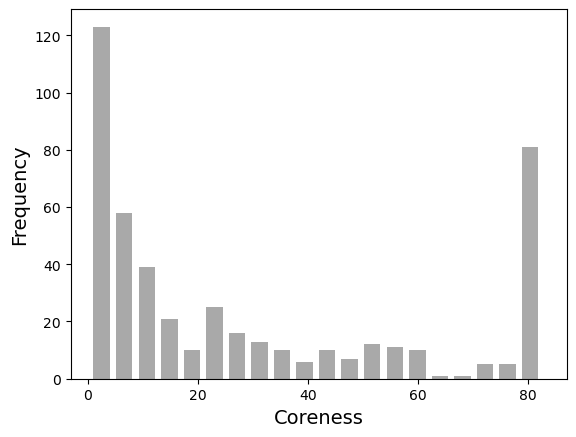

In [10]:
g_airport.vs['core'] = g_airport.coreness(mode='all')
plt.hist(g_airport.vs['core'], bins=20, width=3, color=colors[2]);
plt.xlabel('Coreness', fontsize=14)
plt.ylabel('Frequency', fontsize=14);


In [11]:
## print the airports with maximal coreness:
max_core = np.max(g_airport.vs['core'])
print([v['name'] for v in g_airport.vs if v['core']==max_core])


['SFO', 'LAX', 'MCO', 'ATL', 'JFK', 'FLL', 'LGA', 'ORD', 'LAS', 'DFW', 'TPA', 'PHX', 'MSP', 'HOU', 'DAL', 'DCA', 'PHL', 'SEA', 'BOS', 'EWR', 'MIA', 'SAN', 'JAX', 'BWI', 'CLT', 'IAD', 'DTW', 'SLC', 'AUS', 'RDU', 'SAT', 'IAH', 'OAK', 'STL', 'MSY', 'ABQ', 'PIT', 'MCI', 'MDW', 'RIC', 'IND', 'MEM', 'BUF', 'MKE', 'CLE', 'CMH', 'OKC', 'TUL', 'BNA', 'BDL', 'BHM', 'OMA', 'CVG', 'LIT']


###  Degree distribution

Below we plot the degree distribution, again with mode='all' (total degree, in and out).
Which airport has maximal degree?

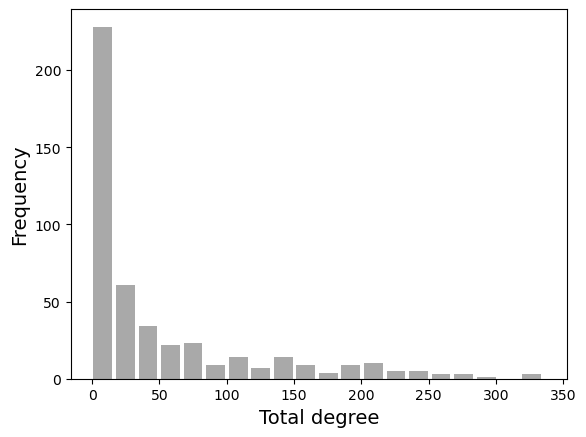

In [12]:
## degree distribution
g_airport.vs['degree'] = g_airport.degree(mode='all')
plt.hist(g_airport.vs['degree'], bins=20, width=14, color=colors[2])
plt.xlabel('Total degree', fontsize=14)
plt.ylabel('Frequency', fontsize=14);


In [13]:
## max degree airport
print('Airport with maximal degree:',g_airport.vs[np.argmax(g_airport.vs['degree'])]['name'])


Airport with maximal degree: ATL


## California Subgraph 

We will look at several **centrality** measures. To speed up the computation and plotting, we consider only the airports in **California**, and the edges within the state.
You can try other states by changing the first line below.


In [14]:
## Build smaller subgraph 'G' for California
g_CA = g_airport.subgraph([v for v in g_airport.vs() if v['state'] == 'CA'])

## drop isolated vertices (i.e. without in-state connections)
g_CA = g_CA.subgraph([v for v in g_CA.vs() if v.degree()>0])

## remove loops if any
g_CA = g_CA.simplify(multiple=False)
print(g_CA.vcount(),'nodes and',g_CA.ecount(),'directed edges')


22 nodes and 134 directed edges


In [15]:
## The graph is weakly connected except for 2 airports
conn_comp = g_CA.connected_components(mode='weak').membership
giant_comp = mode(conn_comp)
g_CA.vs['color'] = colors[2]
print('Nodes outside the giant component:')
for i in range(g_CA.vcount()):
    if conn_comp[i] != giant:
        print(g_CA.vs[i]['name'],'has in degree',g_CA.degree(i,mode='in'),
              'and out degree',g_CA.degree(i,mode='out'))
        g_CA.vs[i]['color'] = colors[4] ## darker color


Nodes outside the giant component:
MCE has in degree 1 and out degree 1
VIS has in degree 1 and out degree 1


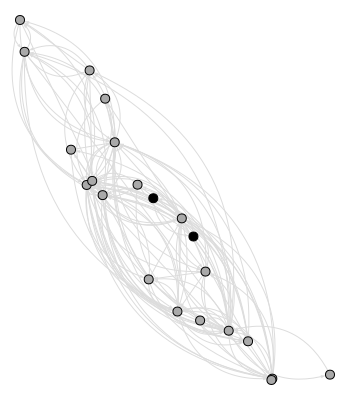

In [16]:
## plot this subgraph using lat/lon as layout
ly = ig.Layout(g_CA.vs['layout'])
## y-axis goes top-down thus the inversion
ly.mirror(1)
ig.plot(g_CA, bbox=(0,0,350,400), layout=ly)


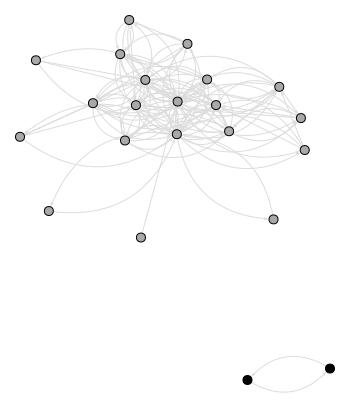

In [17]:
## same subgraph using a force directed layout
ly = g_CA.layout_fruchterman_reingold()
ig.plot(g_CA, bbox=(0,0,350,400), layout=ly)


## Centrality measures

Most measures defined in Chapter 3 of the book are available directly in ```igraph```.

We compute the following centrality measures for the weighted graph g_CA:
**PageRank**, **Authority** and **Hub**.
For **degree centrality**, we define our own function below and we normalize the weights to get values bounded above by 1. 

For the distance based centrality measures **closeness**, **harmonic** and **betweenness**, we do not use the edges weights, so the distance between nodes is the number of hops, and is not based on the number of passengers. This is a natural choice here, since distance between airports (cities) can be viewed as the number of flights needed to travel between those cities.

We compute the above centrality for every node in the g_CA subgraph.

#### Warning for disconnected graphs

The ```igraph``` function to compute **closeness centrality** considers connected components separately. Thus for example the two isolated nodes (with an edge between them) would get maximal value 1 for their centrality. We define our own function to compute closeness centrality as defined in the book, replacing distance (number of hops) with the total number of nodes when no path exists between two nodes.


In [18]:
## compute the normalized edge weights 
max_weight = np.max(g_CA.es['weight'])
g_CA.es()['normalized_weight'] = [w/max_weight for w in g_CA.es()['weight']]

## directed degree centrality
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(g.strength(mode='in',weights=weights),\
              g.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in g.strength(weights=weights)]
    return dc

## use distance = number of nodes below if disconnected
def closeness_centrality(g):
    n = g.vcount()
    D = np.array(g.distances(mode='all'))
    D[D==inf] = n
    return [(n-1)/sum(D[i]) for i in range(len(D))]    


In [19]:
## compute several centrality measures for the California subgraph g_CA
df_central = pd.DataFrame({'airport':g_CA.vs()['name'],
                           'degree':degree_centrality(g_CA,weights='normalized_weight'),\
                           'pagerank':g_CA.pagerank(weights='weight'),
                           'authority':g_CA.authority_score(weights='weight'),\
                           'hub':g_CA.hub_score(weights='weight'),'between':g_CA.betweenness(),\
                           'harmonic':g_CA.harmonic_centrality(),\
                           'closeness':closeness_centrality(g_CA),\
                           'eccentricity':g_CA.eccentricity()})

## normalize the betweenness values
n = g_CA.vcount()
df_central['between'] = [2*x/((n-1)*(n-2)) for x in df_central['between']]

## sort w.r.t. degree centrality, look at top airports
df_central = df_central.sort_values(by='degree', ascending=False)
df_central.head(5)


,airport,degree,pagerank,authority,hub,between,harmonic,closeness,eccentricity
1,LAX,0.117413,0.214569,1.000000,1.000000,0.506905,0.833333,0.318182,2.0
0,SFO,0.089682,0.173044,0.969799,0.906676,0.362290,0.833333,0.318182,2.0
2,SAN,0.079369,0.123509,0.688636,0.725553,0.014218,0.690476,0.291667,2.0
3,OAK,0.046547,0.072727,0.473682,0.441193,0.030420,0.666667,0.287671,2.0
5,SJC,0.041946,0.066523,0.415783,0.389968,0.047324,0.738095,0.300000,2.0


In [20]:
## bottom ones
df_central.tail(5)


,airport,degree,pagerank,authority,hub,between,harmonic,closeness,eccentricity
17,CEC,4.012818e-04,0.007573,0.004617,0.004542,0.000794,0.555556,0.265823,3.0
18,IPL,2.823089e-04,0.007259,0.003998,0.003833,0.000000,0.452381,0.250000,3.0
19,MCE,3.090720e-05,0.045455,0.000000,0.000000,0.000000,0.047619,0.047619,1.0
20,VIS,3.090720e-05,0.045455,0.000000,0.000000,0.000000,0.047619,0.047619,1.0
21,NZY,8.915539e-07,0.006818,0.000000,0.000023,0.000000,0.452381,0.250000,3.0


#### Top airports

The above results agree with intuition in terms of the most central airports in California.
Note however that **SAN** (San Diego) has high values *except* for betweenness, an indication that connecting flights transit mainly via LAX or SFO. 

Below, we plot the California graph again, highlighting the top-3 airports w.r.t. **pagerank**: LAX, SFO, SAN.

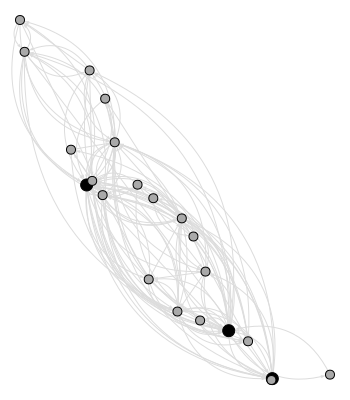

In [21]:
## reset node colours
g_CA.vs()['color'] = colors[2]

## highlight top-3 airports w.r.t. pagerank
g_CA.vs()['pagerank'] = df_central['pagerank']
for x in np.argsort(g_CA.vs()['pagerank'])[-3:]:
    g_CA.vs()[x]['color'] = colors[4]
    g_CA.vs()[x]['size'] = node_sizes[2]
ly = ig.Layout(g_CA.vs['layout'])
ly.mirror(1)
ig.plot(g_CA,bbox=(0,0,350,400),layout=ly)


## Correlation between measures

We use the rank-based **Kendall-tau** correlation to compare the different centrality measures.

We observe high agreement between all measures. In particular, degree-centrality, hub and authority measures are very highly correlated, and so are the distance-based measures (betweenness, closeness).

In [22]:
## rank-based correlation between measures
df_kt = df_central.corr('kendall', numeric_only=True)
df_kt


,degree,pagerank,authority,hub,between,harmonic,closeness,eccentricity
degree,1.000000,0.773913,0.986909,0.973913,0.708075,0.796585,0.811692,-0.260542
pagerank,0.773913,1.000000,0.759833,0.747826,0.578493,0.575311,0.589918,-0.544770
authority,0.986909,0.759833,1.000000,0.995643,0.701878,0.800071,0.815244,-0.249788
hub,0.973913,0.747826,0.995643,1.000000,0.698819,0.805436,0.820563,-0.236856
between,0.708075,0.578493,0.701878,0.698819,1.000000,0.866749,0.854544,-0.308843
harmonic,0.796585,0.575311,0.800071,0.805436,0.866749,1.000000,0.988716,-0.253141
closeness,0.811692,0.589918,0.815244,0.820563,0.854544,0.988716,1.000000,-0.265794
eccentricity,-0.260542,-0.544770,-0.249788,-0.236856,-0.308843,-0.253141,-0.265794,1.000000


### Harmonic vc closeness centrality

By default, closeness centrality is computed **separately** on each **connected component**, which is why we defined our own function earlier, setting the distance equal to the number of nodes when no path exists between two nodes.
This is one advantage of harmonic centrality, which works as is even with disconnected graphs.
We illustrate this below, where we compute the 3 measures (harmonic, closeness with default behavior, closeness with our own definition). We report he results for 5 airports:

* 3 major airports (LAX, SFO, SAN): all values are high
* 2 disconnected airports (MCE, VIS): we see low values expect when using the closeness centrality with default behavior, in which case the value is maximal (1). This can be misleading!

There is a similar concern when computing **eccentricity** (maximum shortest distance), which is done separately for each connected component. For the California subgraph, all nodes have value 2 or 3, except the to disconnected airports, which have value of 1. 

In [23]:
## Harmonic vs closeness centralities
look_at = ['LAX','SFO','SAN','MCE','VIS']
df_central['closeness_default'] = g_CA.closeness()
df_sub = df_central[df_central.airport.isin(look_at)][['airport','harmonic','closeness',
                                              'closeness_default','eccentricity']]
print(df_sub)
# print(df_sub.to_latex(index=False,float_format="%.3f"))


   airport  harmonic  closeness  closeness_default  eccentricity
1      LAX  0.833333   0.318182           0.863636           2.0
0      SFO  0.833333   0.318182           0.863636           2.0
2      SAN  0.690476   0.291667           0.678571           2.0
19     MCE  0.047619   0.047619           1.000000           1.0
20     VIS  0.047619   0.047619           1.000000           1.0


## Looking at coreness

We already looked at coreness for the whole airports graph, now we look at the California subgraph, again with mode='all'. Below we show nodes with maximal coreness as larger black dots, and nodes with small coreness as smaller dots.

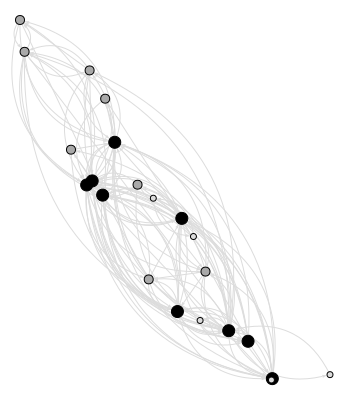

In [24]:
## plot nodes w.r.t. coreness
g_CA.vs['color'] = colors[2]
g_CA.vs['size'] = node_sizes[1]
g_CA.vs()['core'] = g_CA.coreness()
max_core = np.max(g_CA.vs()['core'])
min_core = np.min(g_CA.vs()['core'])
for v in g_CA.vs():
    if v['core'] == max_core:
        v['color'] = colors[4]
        v['size'] = node_sizes[2]
    if v['core'] <= min_core+1:
        v['color'] = colors[0]
        v['size'] = node_sizes[0]
ly = ig.Layout(g_CA.vs['layout'])
ly.mirror(1)
ig.plot(g_CA,bbox=(0,0,350,400),layout=ly)


The above uses the geographical layout, so it is not clear what is going on.

Let's use a force directed layout to make the difference between high and low core number clearer. 

The high coreness nodes are clearly seen, and we aso observe the small 2-node connected component that was buried in the previous visualization.


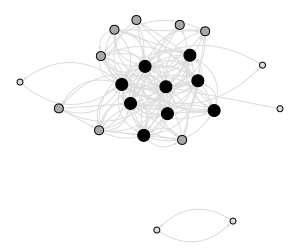

In [25]:
## Coreness is more clear here
ly = g_CA.layout_kamada_kawai()
ig.plot(g_CA, bbox=(0,0,300,250),layout=ly)
#ig.plot(g_CA, 'california_kamada.eps', bbox=(0,0,300,250),layout=ly)


In [26]:
## vertices with max coreness (13-core) 
## note that there are less than 14 nodes, this is an interesting remark and
## it is because we consider both in and out-going edges by default for directed graph.
V = [v['name'] for v in g_CA.vs() if v['core']==max_core]
print('max core value:',max_core, '\nairports:',V)


max core value: 13 
airports: ['SFO', 'LAX', 'SAN', 'OAK', 'SNA', 'SJC', 'SMF', 'FAT', 'SBA']


### Looking at harmonic centrality

Using the same layout as above (with high coreness nodes in the middle), we display the harmonic centrality scores.
We clearly see higher values for central nodes, and small values for the small 2-node component.


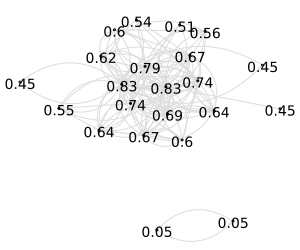

In [27]:
## show closeness centralities, same layout
ix = np.round(g_CA.harmonic_centrality(),decimals=2)
g_CA.vs['size'] = 2
ig.plot(g_CA, vertex_label=ix, layout=ly, bbox=(0,0,300,250))
#ig.plot(g_CA, 'california_harmonic.eps', vertex_label=ix, layout=ly, bbox=(0,0,300,250))


### comparing coreness with other centrality measures

We add coreness to data frame with centrality measures ```df_central```.
We then group the data in 3 categories: high coreness (value of 13), low (value of 2 or less) or mid-range, and we compute and plot the mean for every other measure.

We see that for all centrality measures except closeness centrality, the values are much higher for nodes with high coreness. The slightly higher pagerank value for 'low' coreness nodes vs 'mid' ones is due to the two airports that are not part of the giant component.

As expected, nodes with small coreness generally have smaller centrality scores. 
This is why for example we can often remove the small core nodes (for example, keeping only the 2-core) to reduce
the size of large graphs without destroying its main structure.


In [28]:
## group in 3 categories
g_CA.vs()['Core'] = ['low' if v['core']<=2 else 'high' if v['core']==13 else 'mid' for v in g_CA.vs()]
df_central['Coreness'] = g_CA.vs['Core']
df = df_central.groupby('Coreness').median(numeric_only=True)
df.sort_values(by='degree',inplace=True,ascending=False)
df = df.drop(['closeness','eccentricity','closeness_default'], axis=1)
df


,degree,pagerank,authority,hub,between,harmonic
Coreness,,,,,,
high,0.041946,0.066523,0.415783,0.389968,0.035692,0.738095
mid,0.001379,0.008936,0.017793,0.017627,0.001213,0.575397
low,0.000031,0.007644,0.000000,0.000023,0.000000,0.452381


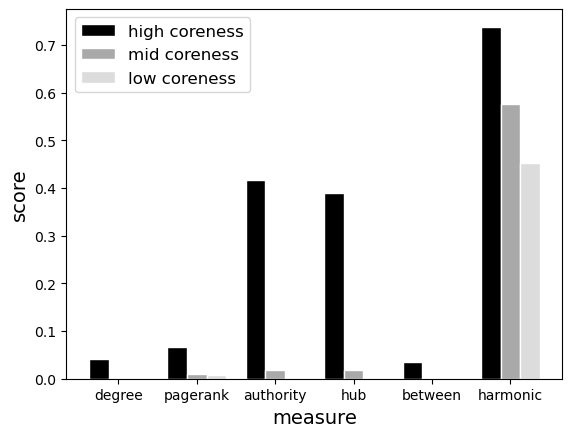

In [29]:
## grouped barplot
bh = np.array(df.loc[['high']])[0]
bm = np.array(df.loc[['mid']])[0]
bl = np.array(df.loc[['low']])[0]
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(bh))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bh, color=colors[4], width=barWidth, edgecolor='white', label='high coreness')
plt.bar(r2, bm, color=colors[2], width=barWidth, edgecolor='white', label='mid coreness')
plt.bar(r3, bl, color=colors[0], width=barWidth, edgecolor='white', label='low coreness')
 
# Add xticks on the middle of the group bars
plt.xlabel('measure',fontsize=14)
plt.xticks([r + barWidth for r in range(len(bh))], df.columns, fontsize=10)
plt.ylabel('score',fontsize=14) 

# Create legend & Show graphic
plt.legend(fontsize=12);
#plt.savefig('California_core_vs_measures.eps');


## Delta-centrality example

This is the simple ''pandemic'' spread model as detailed in the book:

*The ''pandemic'' starts at exactly one airport selected uniformly at random from all the airports. Then, the following rules for spreading are applied: (i) in a given airport pandemic lasts only for one round and (ii) in the next round, with probability $\alpha$, the pandemic spreads independently along the flight routes to the destination airports for all connections starting from this airport. Airports can interact with the pandemic many times, and the process either goes on forever or the pandemic eventually dies out. Our goal is to find the expected number of times a given airport interacted with the pandemic, which amounts to the sum over all airports of the expected number of times this airport has the pandemic.*

We use $\alpha$ = 0.1 and plot the (decreasing) delta centrality values in a barplot, using the same 3 colors are with the coreness plot above.

In [30]:
## Delta-centrality with a simple pandemic spread model
def spread(g, alpha=0.1):
    n = g.vcount()
    I = np.diag(np.repeat(1,n))
    A = np.array(g.get_adjacency().data)
    One = np.ones((n,1))
    X = np.linalg.inv(I-alpha*np.transpose(A))
    Y = np.reshape(X.dot(One)/n,n)
    return np.sum(Y)

def spread_delta_centrality(g, alpha=0.1):
    dc = []
    spr = spread(g, alpha=alpha) # P(G) in the book
    for i in g.vs():
        G = g.copy()
        el = g.incident(i, mode='ALL')
        G.delete_edges(el)
        dc.append((spr-spread(G, alpha=alpha))/spr)
    return dc

print('Overall CA subgraph:',spread(g_CA))

Overall CA subgraph: 6.940268816862362


In [31]:
## run the spread model with alpha = 0.1 and show the top airports
g_CA.vs['delta'] = spread_delta_centrality(g_CA, alpha=.1)
df_spread = pd.DataFrame(np.transpose([g_CA.vs['name'],g_CA.vs['delta'],
                                       g_CA.vs['color']]),columns=['airport','delta','color'])
df_spread.sort_values(by='delta', ascending=False, inplace=True)
df_spread.head()


,airport,delta,color
0,SFO,0.5781442103552327,black
1,LAX,0.5765987683670661,black
6,SMF,0.5118313161868462,black
5,SJC,0.4674047555218681,black
2,SAN,0.4327191367894436,black


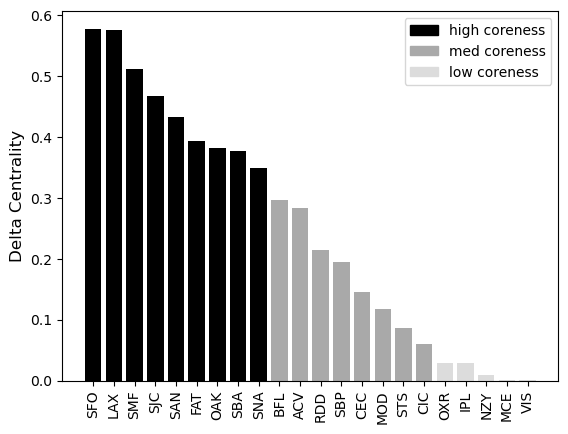

In [32]:
## plot using the same colors as with coreness plot
heights = [float(x) for x in df_spread['delta']]
bars = df_spread['airport']
y_pos = range(len(bars))
plt.bar(y_pos, heights, color=df_spread['color'] )

# Rotation of the bars names
plt.ylabel('Delta Centrality',fontsize=12)
plt.xticks(y_pos, bars, rotation=90)
plt.yticks();

# legend
color_dict = {'high coreness':colors[4], 'med coreness':colors[2], 'low coreness':colors[0]}         
labels = list(color_dict.keys())
handles = [plt.Rectangle((0,0),1,1, color=color_dict[label]) for label in labels]
plt.legend(handles, labels);


## Group centrality and centralization

We go back to the full airports graph, and we ask the following questions:

* which states have highest delta centralities with respect to efficiency?
* what about centralization for each state subgraph?

Computing efficiency involves the computation of shortest path lengths, which will cause a warning if the graph is disconnected. Warnings can be turned off by un-commenting the next cell.


In [33]:
## efficiency function given g
def efficiency(g):
    n = g.vcount()
    s = 0
    for i in range(n):
        v = g.get_shortest_paths(i)
        s += np.sum([1/(len(x)-1) for x in v if len(x) > 1])
    return s/(n*(n-1))

## group delta centrality -- we compute for each state
states = list(set(g_airport.vs()['state']))
eff_us = efficiency(g_airport)
dc = []
for s in states:
    v = [x for x in g_airport.vs() if x['state']==s]
    G = g_airport.copy()
    e = []
    for x in v:
        e.extend(g_airport.incident(x, mode='ALL'))
    G.delete_edges(e)
    dc.append((eff_us-efficiency(G))/eff_us)

## sort and show top states
DC = pd.DataFrame({'state':states, 'delta_centrality':dc})
DC = DC.sort_values(by='delta_centrality', ascending=False)
DC.head(5)


/tmp/ipykernel_2161529/4246715804.py:6: RuntimeWarning: Couldn't reach some vertices at src/paths/unweighted.c:440
  v = g.get_shortest_paths(i)


,state,delta_centrality
41,TX,0.159289
10,CA,0.134366
0,FL,0.113134
26,NY,0.076745
11,PA,0.072355


In [34]:
## ... and bottom states
DC.tail(5)


,state,delta_centrality
44,CT,0.013733
12,VT,0.008770
17,DE,0.008410
40,RI,0.005541
4,NH,0.005343


For group centralization, we use the PageRank measure.

In [35]:
## group centralization (using PageRank) -- by state
## look at states with more than 5 airports only
states = list(set(g_airport.vs()['state']))
page_rank = []
st = []
for s in states:
    v = [x for x in g_airport.vs() if x['state']==s]
    if len(v)>5: ## look at states with more than 5 airports only
        G = g_airport.subgraph(v)
        G = G.simplify(multiple=False) ## drop self-loops
        p = G.pagerank(weights='weight')
        page_rank.append(np.max(p) - np.mean(p))
        st.append(s)

## sort and show top
DC = pd.DataFrame({'State':st, 'Pagerank Centralization':page_rank})
DC = DC.sort_values(by='Pagerank Centralization', ascending=False)
DC.head(5)


,State,Pagerank Centralization
13,MI,0.372879
25,GA,0.360744
12,NC,0.357549
5,PA,0.350522
15,IL,0.344592


We plot the state with highest PageRank centralization (Michigan).

This is a state with one high degree airport (DTW).

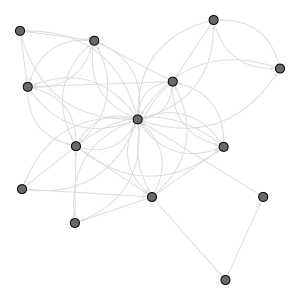

In [36]:
v = [x for x in g_airport.vs() if x['state']=='MI']
G = g_airport.subgraph(v)
G = G.subgraph([v for v in G.vs() if v.degree()>0])
G = G.simplify(multiple=False)
#ig.plot(G, 'central_MI.eps', bbox=(0,0,300,300))
ig.plot(G,bbox=(0,0,300,300))


In [37]:
## one big hub airport: DTW (Detroit)
G.vs['deg'] = G.degree() # overall degree
for v in G.vs:
    print(v['city'],v['name'],'has degree',v['deg'])
    

Detroit DTW has degree 23
Grand Rapids GRR has degree 11
Flint FNT has degree 8
Lansing LAN has degree 7
Saginaw MBS has degree 4
Traverse City TVC has degree 9
Kalamazoo AZO has degree 4
Marquette MQT has degree 9
Muskegon MKG has degree 8
Alpena APN has degree 4
Escanaba ESC has degree 5
Iron Mountain IMT has degree 4
Detroit YIP has degree 2
Battle Creek BTL has degree 2


We plot the state with lowest PageRank centralization (ND).

This is a state without high degree (hub) airport.

In [38]:
## now the bottom  states
DC.tail(5)


,State,Pagerank Centralization
10,SD,0.093510
7,KS,0.093073
20,NE,0.076577
23,AR,0.066612
28,ND,0.061196


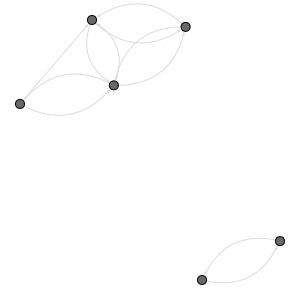

In [39]:
## North Dakota
v = [x for x in g_airport.vs() if x['state']=='ND']
G = g_airport.subgraph(v)
G = G.subgraph([v for v in G.vs() if v.degree()>0])
G = G.simplify(multiple=False)

#ig.plot(G, 'central_ND.eps', bbox=(0,0,300,300))
ig.plot(G, bbox=(0,0,300,300))


In [40]:
## no big hub city here
G.vs['city']


['Fargo', 'Bismarck', 'Grand Forks', 'Minot', 'Williston', 'Dickinson']

What should we expect for California? There are hub airports, but several ones. 

In [41]:
## what about California?
DC[DC['State']=='CA']


,State,Pagerank Centralization
4,CA,0.169906


# Extra material

### Figure 3.1 - empirical tests

The code below can be used to obtain the equivalent of Figure 3.1 in the book for different values of $n$, the number of nodes. Large $n$ values will generate a plot like the one on the book.

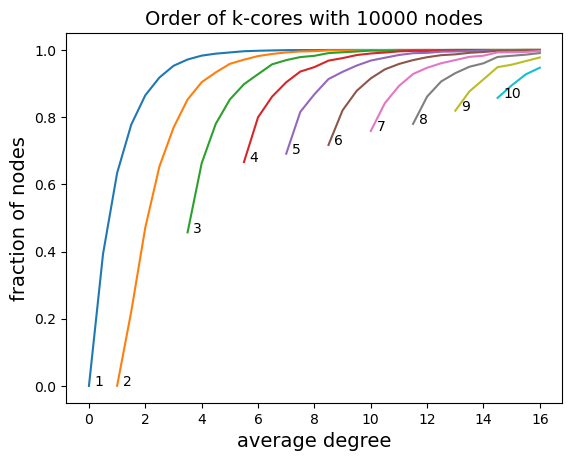

In [42]:
## G(n,p) graph and k-cores - fraction of nodes in k-core vs average degree
n = 10000

## Generate the graphs and store coreness
avg_deg = np.arange(0,16.1,.5)
n_edges = [int(n*i/2) for i in avg_deg]

C = []
for m in n_edges:
    g = ig.Graph.Erdos_Renyi(n=n, m=m)
    C.extend(g.coreness())
C = np.array(C).reshape(len(avg_deg), n)

## Plot
fig, ax = plt.subplots(1)
S = [sum(C[i]>=1)/n for i in range(len(avg_deg))]
X = [avg_deg[i] for i in range(len(avg_deg)) if S[i]>=0]
Y = [S[i] for i in range(len(avg_deg)) if S[i]>=0]
ax.plot(X, Y)
ax.text(0.2,0,'1')

for k in np.arange(2,11,1):
    S = [sum(C[i]>=k)/n for i in range(len(avg_deg))]
    X = [avg_deg[i] for i in range(len(avg_deg)) if S[i]>0]
    Y = [S[i] for i in range(len(avg_deg)) if S[i]>0]
    ax.plot(X, Y)
    ax.text(np.min(X)+.2, np.min(Y), str(k))

ax.set_xlabel('average degree', fontsize=14)
ax.set_ylabel('fraction of nodes', fontsize=14)
ax.set_title('Order of k-cores with '+str(n)+' nodes',fontsize=14);


In [88]:
g_airport.vs[0]

igraph.Vertex(<igraph.Graph object at 0x7fdfae3cc650>, 0, {'name': 'SFO', 'layout': (-122.375, 37.6189994812012), 'state': 'CA', 'city': 'San Francisco', 'size': 9, 'color': 'dimgray', 'core': 83, 'degree': 190})

In [94]:
V = [v for v in g_airport.vs if v['state'] in ['CA','NY']]
sg = g_airport.subgraph(V)
sg = sg.connected_components(mode='weak').giant()
sg = sg.simplify()
sg = sg.as_undirected()

In [95]:
from fastnode2vec import Graph, Node2Vec
graph = Graph(sg.to_tuple_list(), directed=False, weighted=False)

Reading graph:   0%|          | 0/127 [00:00<?, ?it/s]

In [96]:
n2v = Node2Vec(graph, dim=2, walk_length=100, window=5, workers=32)
n2v.train(epochs=100)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

In [97]:
sg.vcount()

33

In [102]:
for v in sg.vs:
    if v['state'] == 'NY':
        v['color'] = 'red'
    else:
        v['color'] = 'blue'


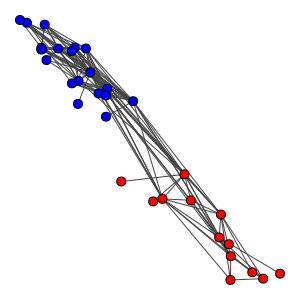

In [103]:
ly = [n2v.wv[i] for i in range(33)]
ig.plot(sg, layout=ly, bbox=(300,300))